In [2]:
import glob
import os
from collections import Counter
from itertools import combinations, product

import numpy as np
np.random.seed(18012023)

import pandas as pd
pd.set_option('display.max_colwidth', 0)

import seaborn as sb

from sklearn.metrics import pairwise_distances
import lxml.etree
from scipy.spatial.distance import pdist, squareform
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, precision_score, recall_score, \
                            precision_recall_curve, average_precision_score, \
                            roc_auc_score
import matplotlib.pyplot as plt
import matplotlib
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.family'] = 'Arial'
from IPython.display import display

In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/mikekestemont/anaconda3/envs/n36/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases

In [40]:
fig_dir = '../figures'
if not os.path.isdir(fig_dir):
    os.mkdir(fig_dir)

## Load (meta)data

In [41]:
meta_df = pd.read_excel('../data/metadata_corrected.xlsx')
meta_df = meta_df[meta_df['exclude'] != 'x']
meta_df.sample(10)

,id,title,author,date,provenance,date_range,genre,subgenre,exclude
47,derde_martijn,Derde Martijn,Jacob van Maerlant,1402.5,cdrom-mnl,1380-1425,Lyriek,NaN,NaN
82,haagse_liederenhs,Haagse liederenhandschrift,NaN,1400.0,cdrom-mnl,1390-1410,Lyriek,NaN,NaN
167,Reinout van Montalbaen,Reinout van Montalbaen,NaN,1288.0,CG1,1300-1276,Epiek,Karel,NaN
219,spiegel_historiael__2_fragm_ah,Spiegel historiael (P2),Philip Utenbroeke,1325.0,cdrom-mnl,1300-1350,Epiek,Historiografie,NaN
56,esmoreit,Esmoreit,NaN,1410.0,cdrom-mnl,1400-1420,Dramatiek,NaN,NaN
266,van_ses_vaerwen,Van ses vaerwen ende twaelf outheyden,NaN,1410.0,cdrom-mnl,1400-1420,Epiek,Didactiek,NaN
116,madelgijs_fragm_le2,Madelgijs,NaN,1375.0,cdrom-mnl,1350-1400,Epiek,Karel,NaN
263,van_ons_heren_wonden,Van ons heren wonden,NaN,1425.0,cdrom-mnl,1400-1450,Lyriek,NaN,NaN
71,gedicht_over_de_hemeltekenen,Gedicht over de hemeltekenen,NaN,1350.0,cdrom-mnl,1340-1360,Epiek,Didactiek,NaN
73,geraert_van_viane,Geraert van Viane,NaN,1325.0,cdrom-mnl,1300-1350,Epiek,Karel,NaN


In [42]:
def get_verse_groups(verses, size=2, intertexts=False):
    for i in range(len(verses) - (size - 1)):
        if not intertexts:
            yield ' / '.join(verses[i : i + size])
        else:
            its = Counter(verses[i : i + size])
            if None in its:
                yield None
            elif len(its) > 1:
                yield 'overlap'
            else:
                yield list(its.keys())[0]

In [43]:
def parse_xml(fn, rm_interpol=False):
    try:
        tree = lxml.etree.parse(fn)
    except OSError:
        print(f'- Could not load {fn}')
        return None
        
    if rm_interpol:
        for interpolation in tree.xpath("//interpolation"):
            interpolation.getparent().remove(interpolation)
        
    for line_node in tree.iterfind('//l'):
        try:
            intertext_id = line_node.attrib['intertext']
        except KeyError:
            intertext_id = None
        
        tokens_ = line_node.attrib['tokens'].split()
        lemmas_ = []
        
        lemma_tags = [l.text for l in line_node.iterfind('.//lemma')]
        pos_tags = [p.text for p in line_node.iterfind('.//pos')]
        
        for lemma, pos in zip(lemma_tags, pos_tags):
            for l, p in zip(lemma.split('+'), pos.split('+')):
                    if p == 'n(prop)':
                        lemmas_.append('n(prop)')
                    else:
                        lemmas_.append(l)
    
        yield tokens_, lemmas_, intertext_id

In [44]:
GROUP_SIZE = 2

titles, tokens, lemmas, intertexts = [], [], [], []

for title, group in tqdm(meta_df.groupby('title')):
    work_tokens, work_lemmas, work_intertexts = [], [], []
    
    for id_ in sorted(group['id']):
        for tok, lem, intertext_id in parse_xml(f'../data/xml/{id_}.xml'):
            work_tokens.append(tok)
            work_lemmas.append(lem)
            work_intertexts.append(intertext_id)
    
    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=GROUP_SIZE))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=GROUP_SIZE))
    verse_group_intertexts = list(get_verse_groups(work_intertexts, size=GROUP_SIZE, intertexts=True))

    tokens.extend(verse_group_tokens)
    lemmas.extend(verse_group_lemmas)
    intertexts.extend(verse_group_intertexts)
    titles.extend([title] * len(verse_group_lemmas))

100%|██████████| 205/205 [00:34<00:00,  6.00it/s]


In [45]:
df = pd.DataFrame(zip(titles, tokens, lemmas, intertexts), columns=('title', 'tokens', 'lemmas', 'intertext'))
df = df[df['intertext'] != 'overlap']

In [46]:
def add_rhyme_column(df):
    rhyme_words = []
    for lemmas in df['lemmas']:
        rhymes = []
        for verse in lemmas.split(' / '):
            rhymes.append(verse.strip().split()[-1])
        rhyme_words.append(' '.join(rhymes))
    df['rhyme'] = rhyme_words
    return df

df = add_rhyme_column(df)

In [47]:
optim_vs = 7000
optim_rw = 0.1693877551020408
optim_th = 0.42202047865566794
rolling_size = 1000

In [48]:
def tokenizer(text):
    return text.replace(' / ', ' ').lower().strip().split()

vec = TfidfVectorizer(max_features=optim_vs, min_df=2,
                      tokenizer=tokenizer, token_pattern=None).fit(df['lemmas'])

## Case studies: macro-level

#### Utility functions

In [49]:
def batch(iterable, n=1):
    l = iterable.shape[0]
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

def pairwise(title1, title2, rhyme_weight=.25, batch_size=5000):
    
    A = df[df['title'] == title1]
    B = df[df['title'] == title2]

    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])

    all_distances = None

    for ax in batch(AX, batch_size):
        if all_distances is None:
            all_distances = pairwise_distances(ax, BX, metric='cosine')
        else:
            all_distances = np.append(all_distances,
                                      pairwise_distances(ax, BX, metric='cosine'),
                                      axis=0)
    
    return all_distances

In [50]:
def plot_min_distance_nn(t1, t2, min_dists, threshold, rolling_size=1000):
    mu = min_dists.rolling(rolling_size).mean()
    fig, ax = plt.subplots()
    mu.plot(ax=ax)
    ax.axhline(threshold, ls='--', c='grey')
    ax.set_ylim(0, 1)
    ax.set_xlabel(t1)
    ax.set_ylabel('Distance to NN in ' + t2)
    return ax

In [51]:
def get_interpolations(title):
    fn = meta_df[meta_df['title'] == title]['id'].iloc[0]
    tree = lxml.etree.parse(f'../data/xml/{fn}.xml').getroot()
    interpol_idxs, interpol_names, line_cnt = [], [], 0
    for element in tree:
        line_cnt += 1
        if element.tag == 'interpolation':
            idxs, length = line_cnt, len(element.findall('l'))
            interpol_idxs.append([line_cnt, line_cnt + length])
            line_cnt += length
            interpol_names.append(element.attrib['reason'])      
    return interpol_idxs, interpol_names

#### Case studies

Heelu in de Vijfde Partie:

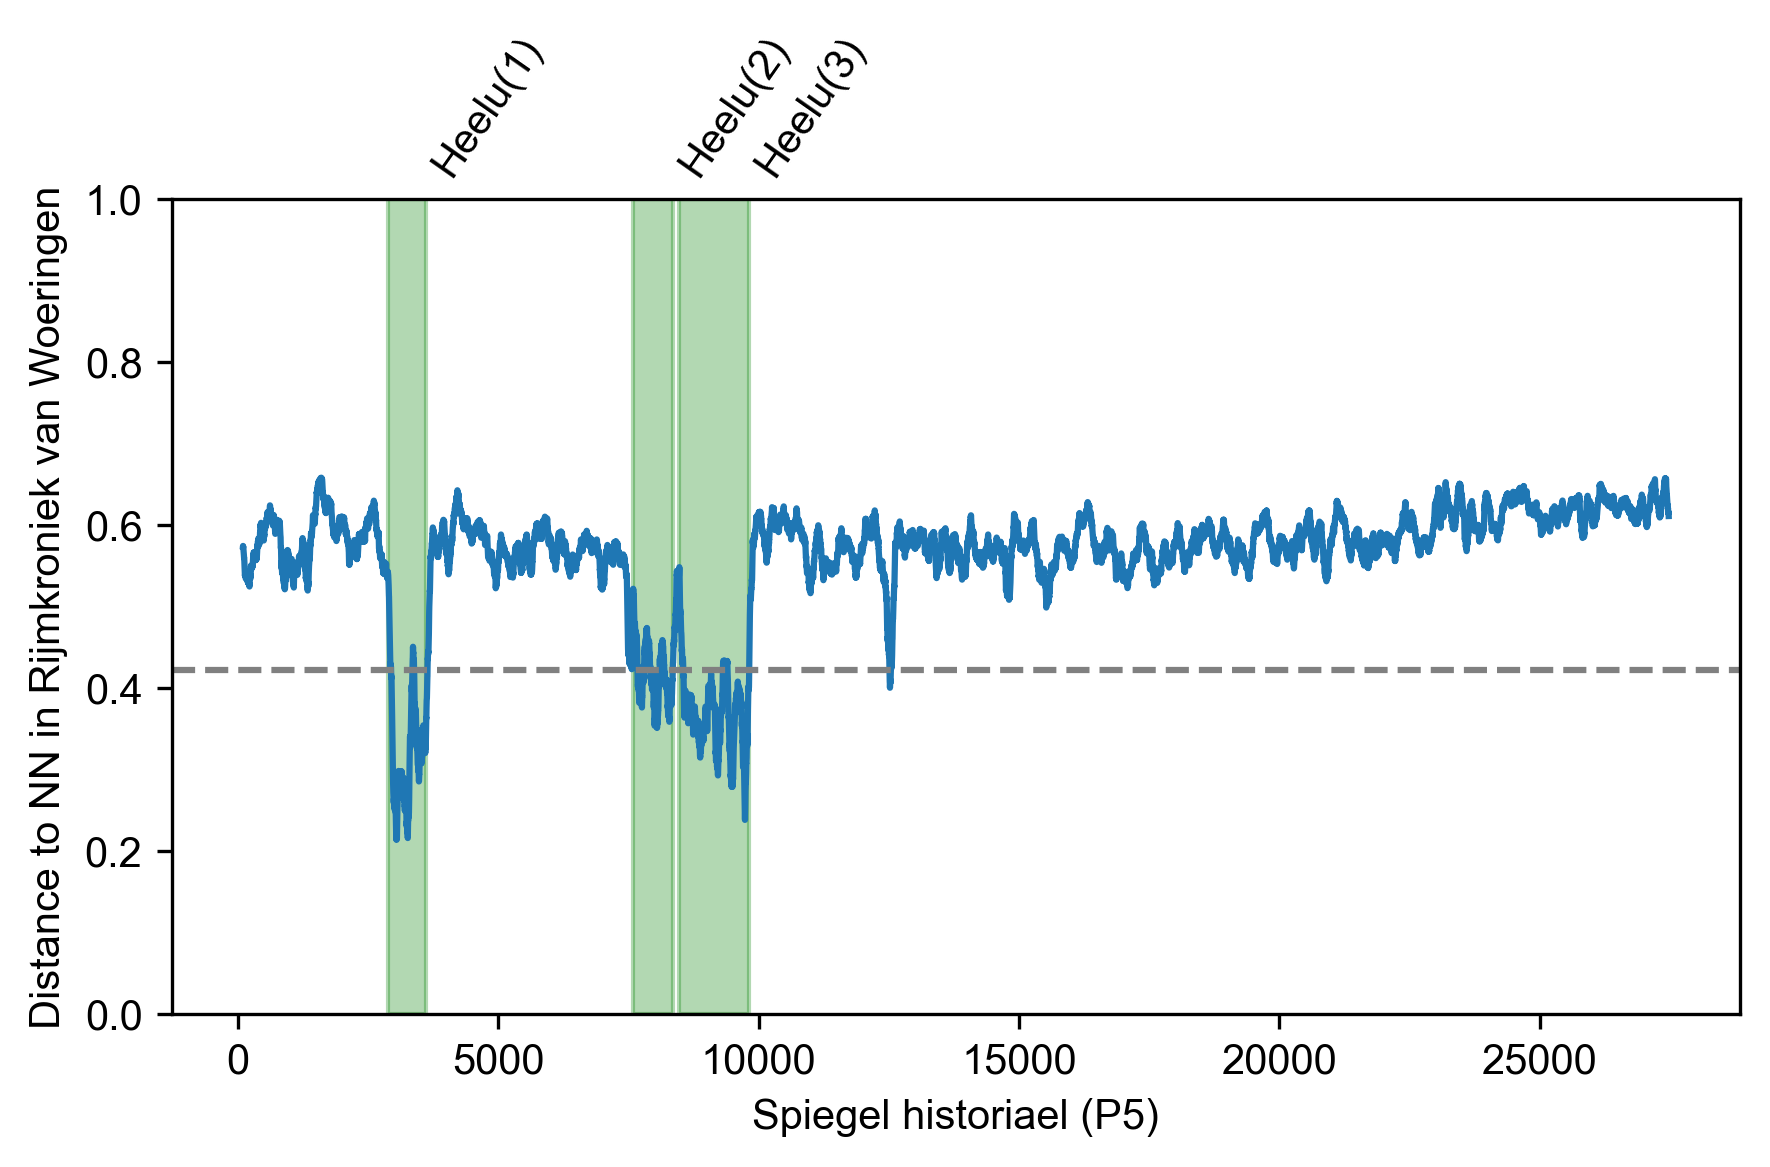

In [52]:
t1, t2 = 'Spiegel historiael (P5)', 'Rijmkroniek van Woeringen'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100)
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if n.startswith('Heelu'):
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/heelu.png');

Maerlant in de Brabantse yeesten:

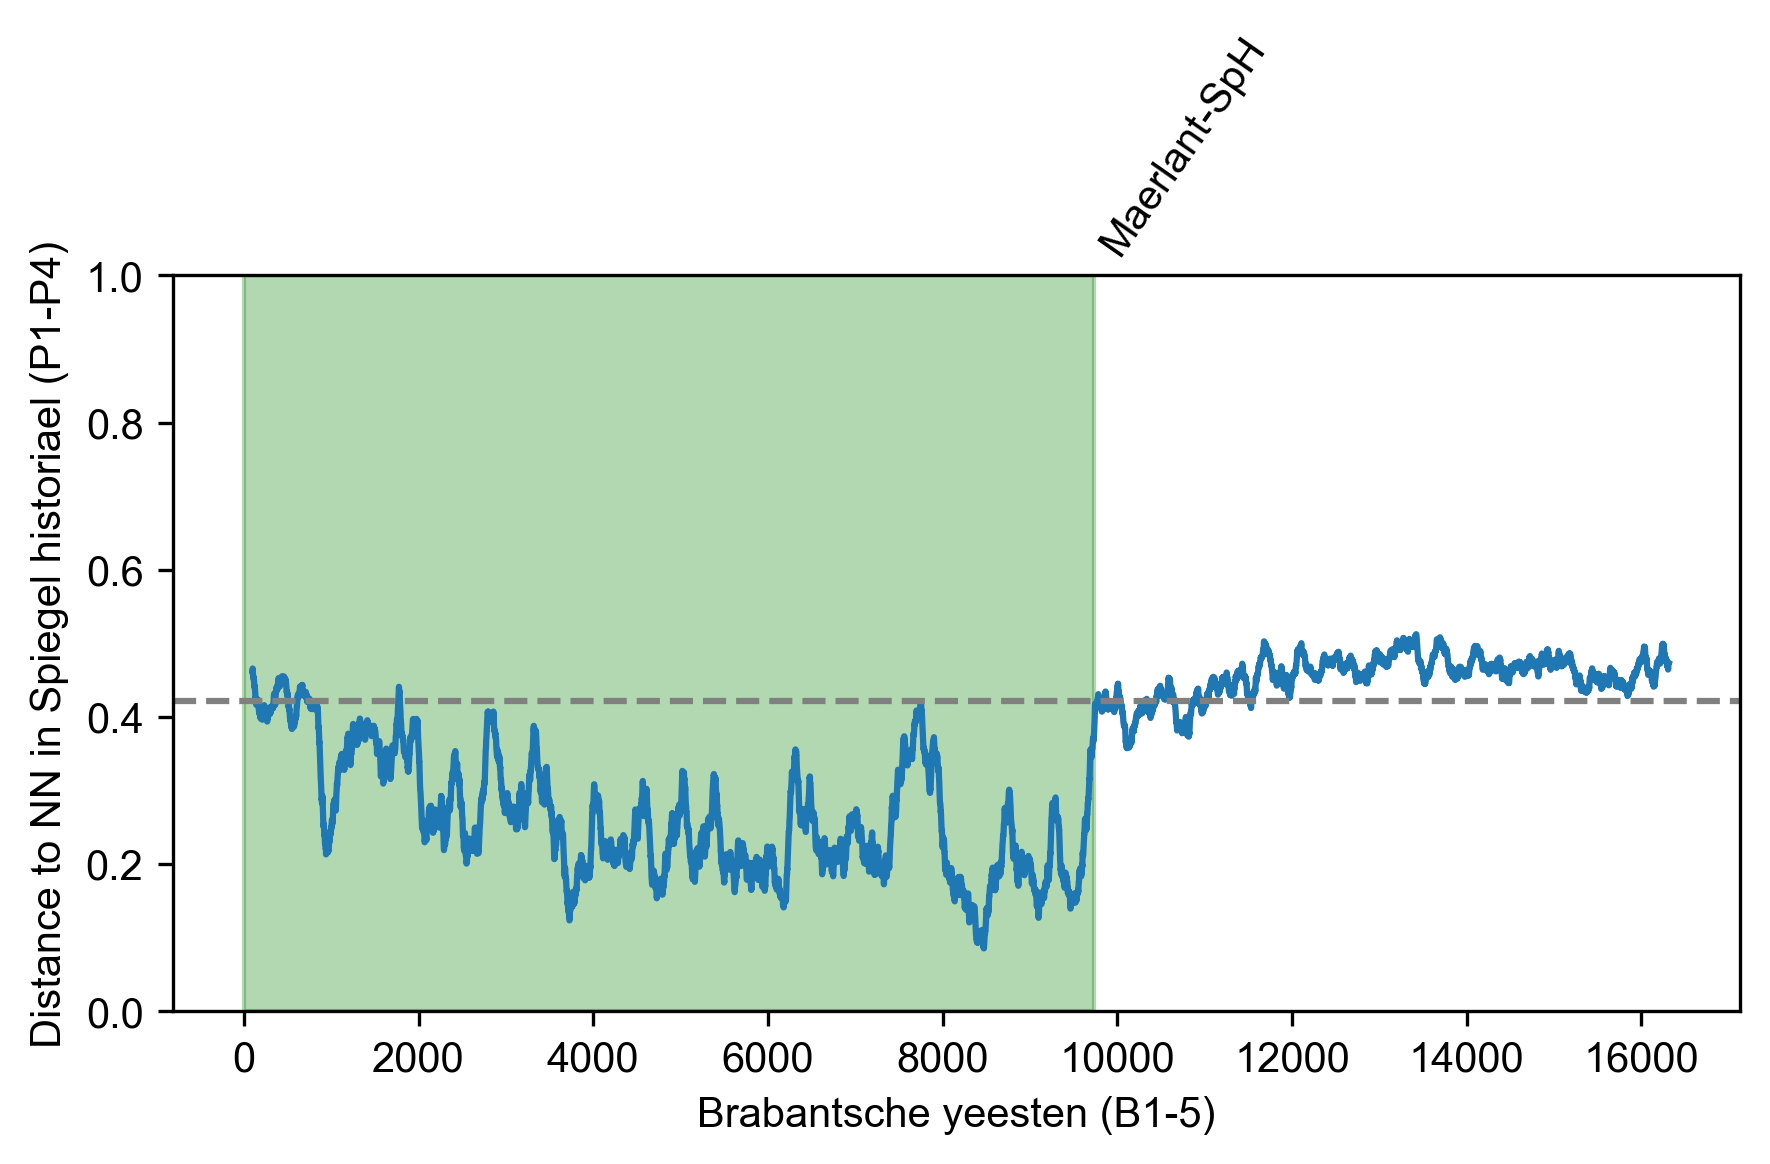

In [53]:
t1, t2 = 'Brabantsche yeesten (B1-5)', 'Spiegel historiael (P1-P4)'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
    plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/yeesten.png');

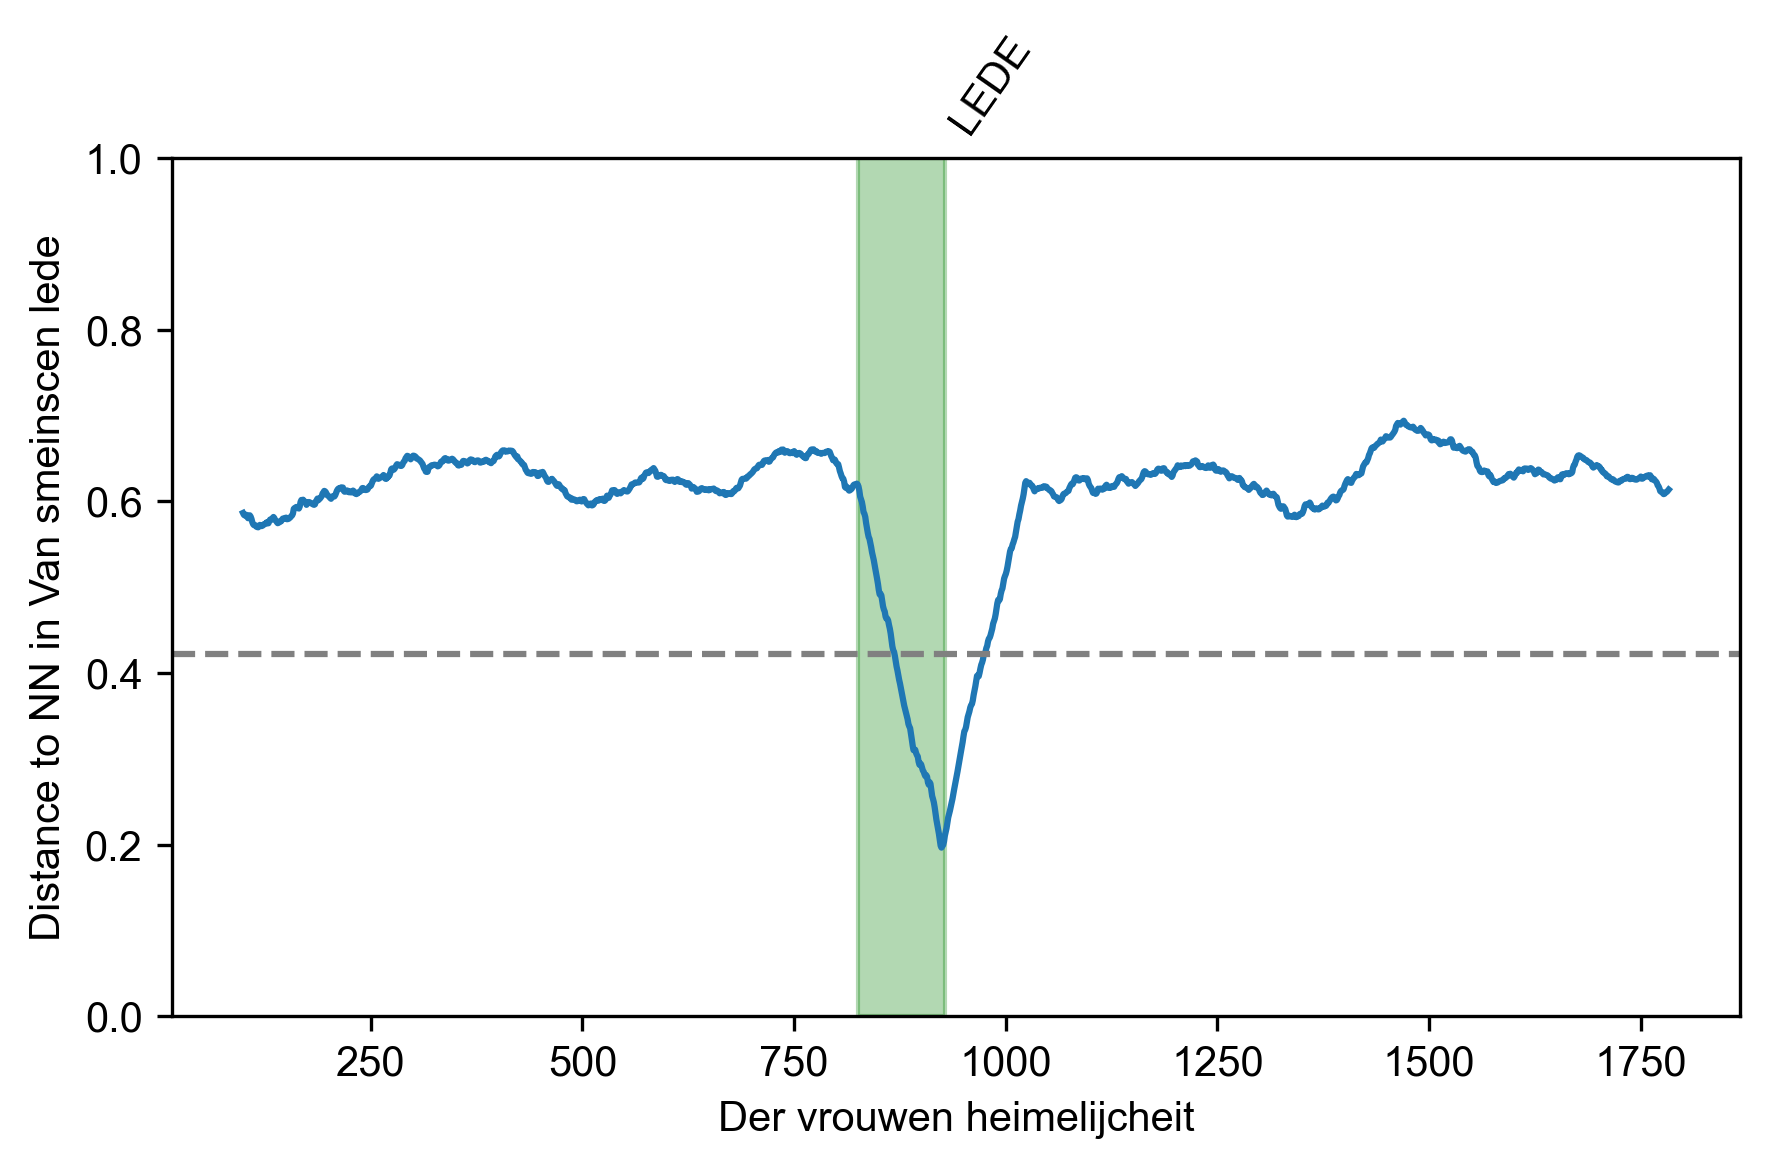

In [54]:
t1, t2 = 'Der vrouwen heimelijcheit', 'Van smeinscen lede'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
    plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/heimelijcheit.png');

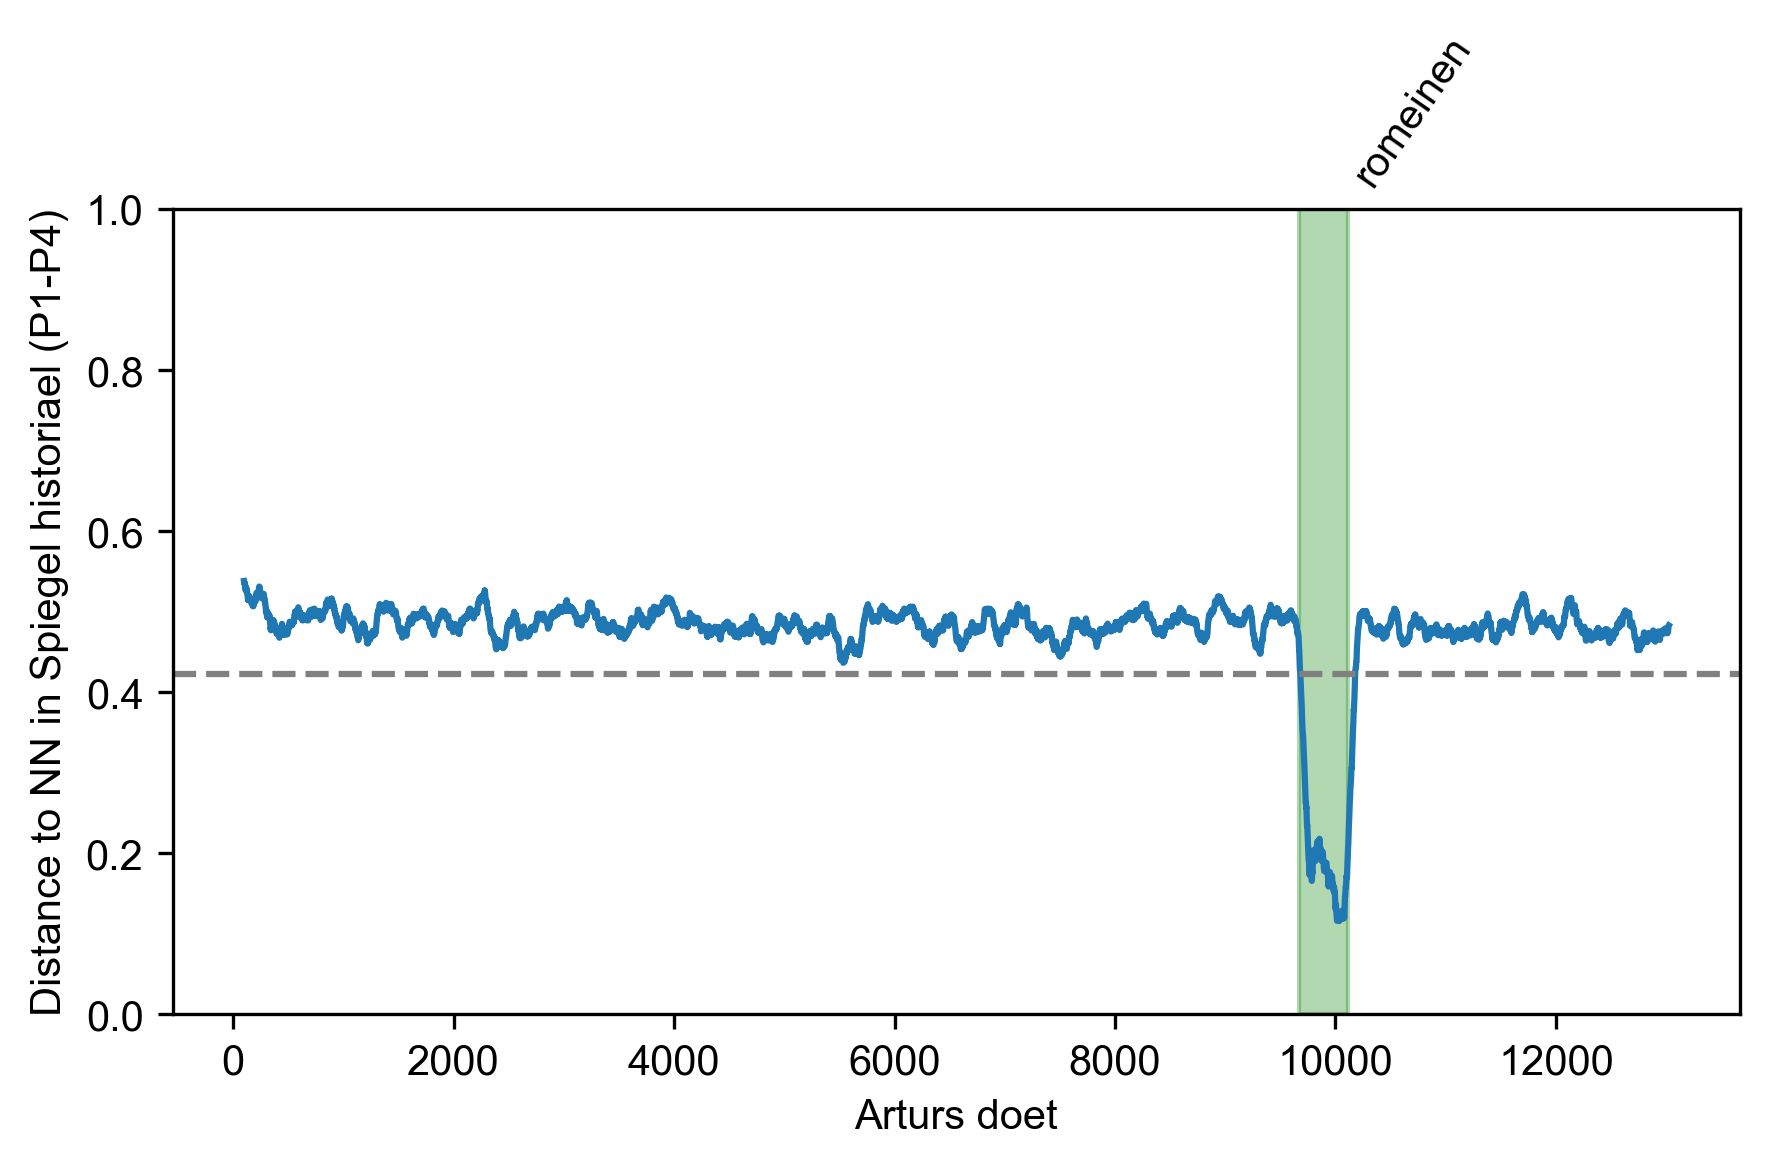

In [55]:
t1, t2 = 'Arturs doet', 'Spiegel historiael (P1-P4)'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if not 'gebed' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/romeinen.png');

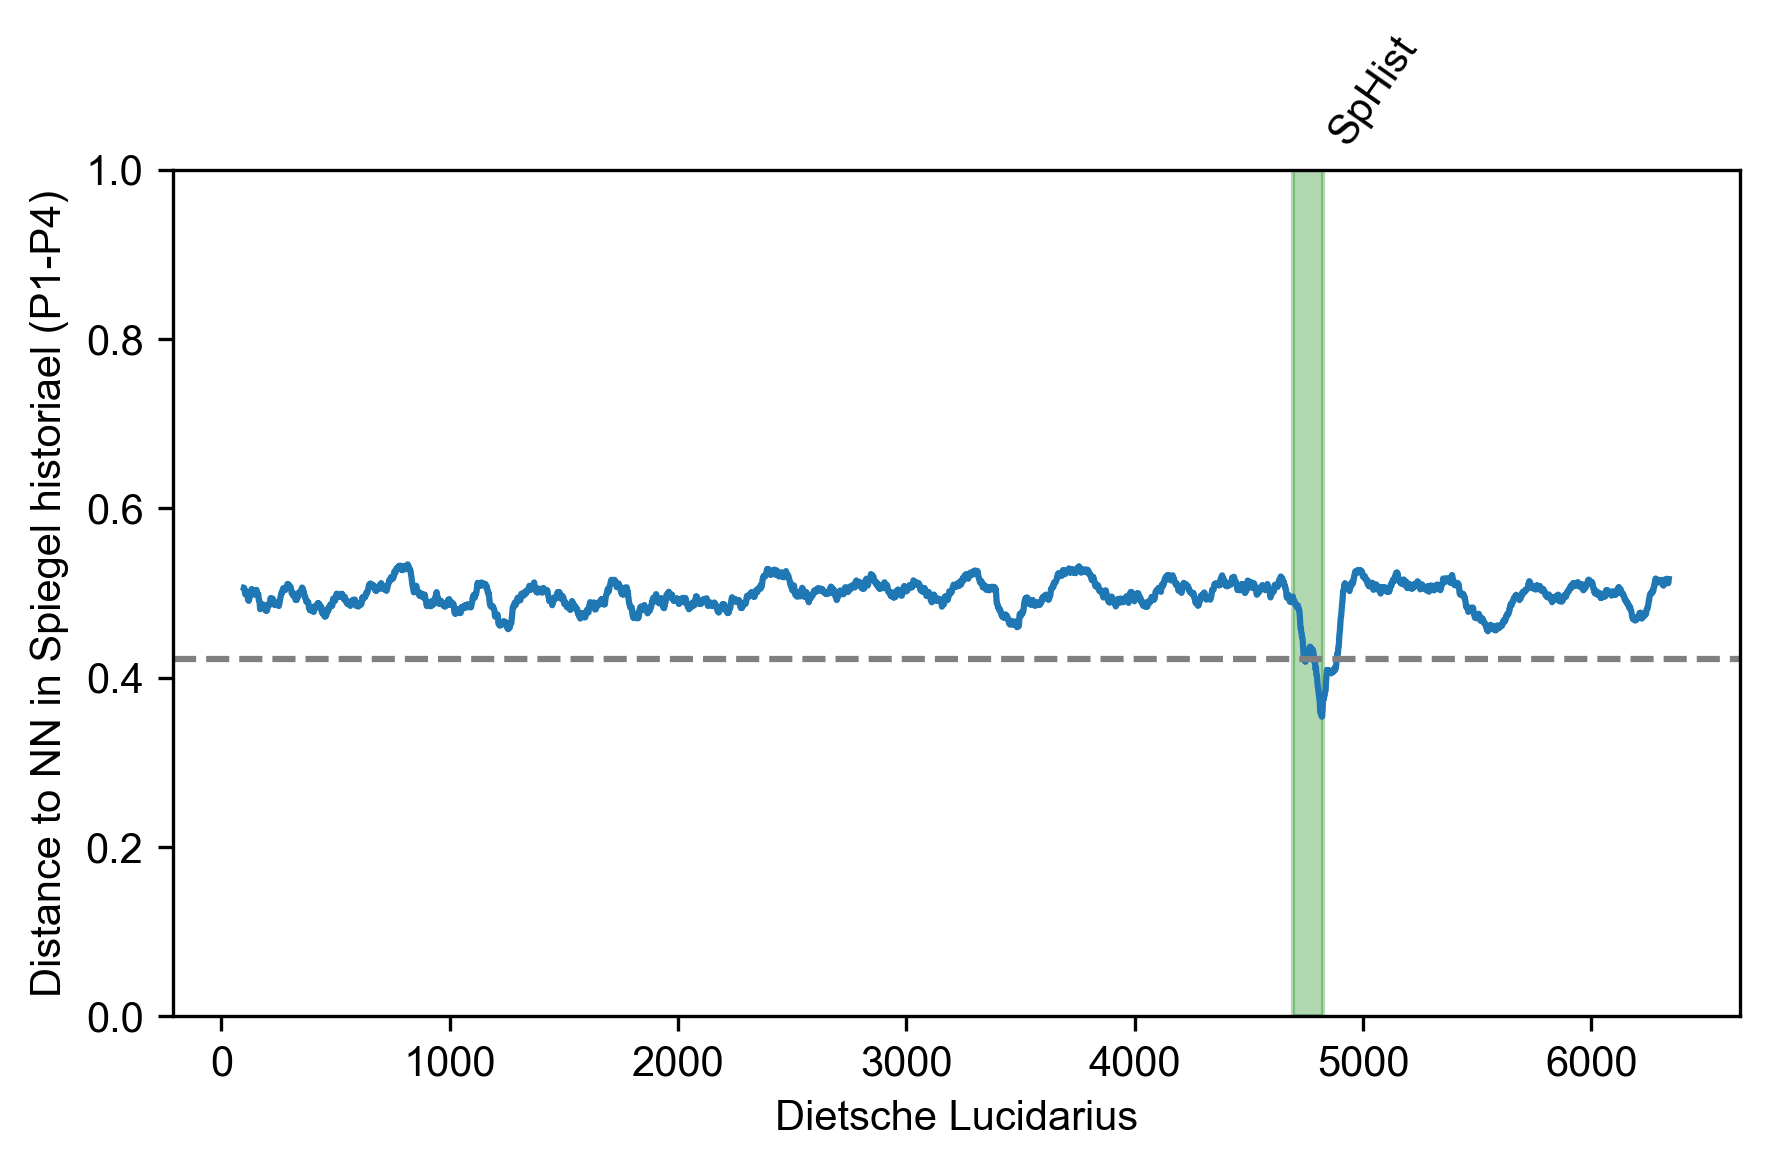

In [56]:
t1, t2 = 'Dietsche Lucidarius', 'Spiegel historiael (P1-P4)'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if 'SpHist' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/lucidarius_sphist.png');

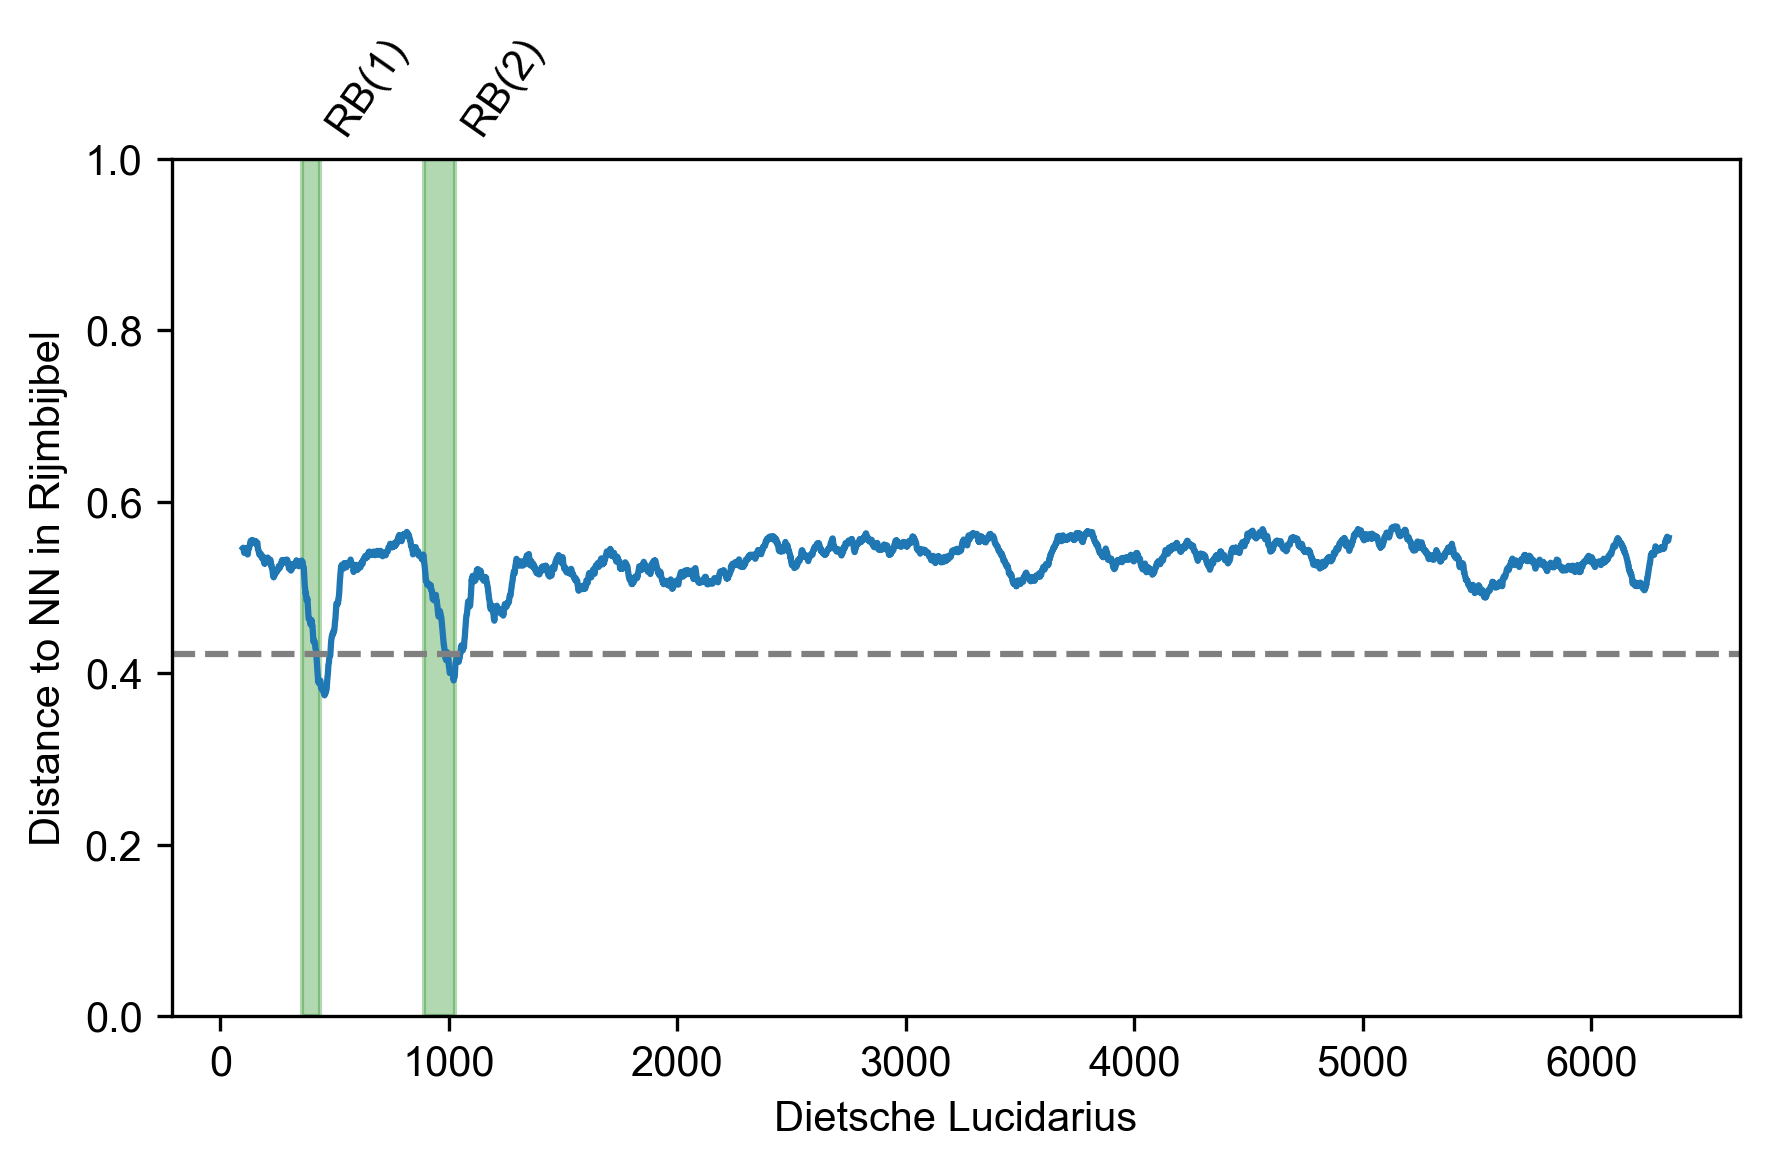

In [57]:
t1, t2 = 'Dietsche Lucidarius', 'Rijmbijbel'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if not 'SpHist' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/lucidarius_rb.png');

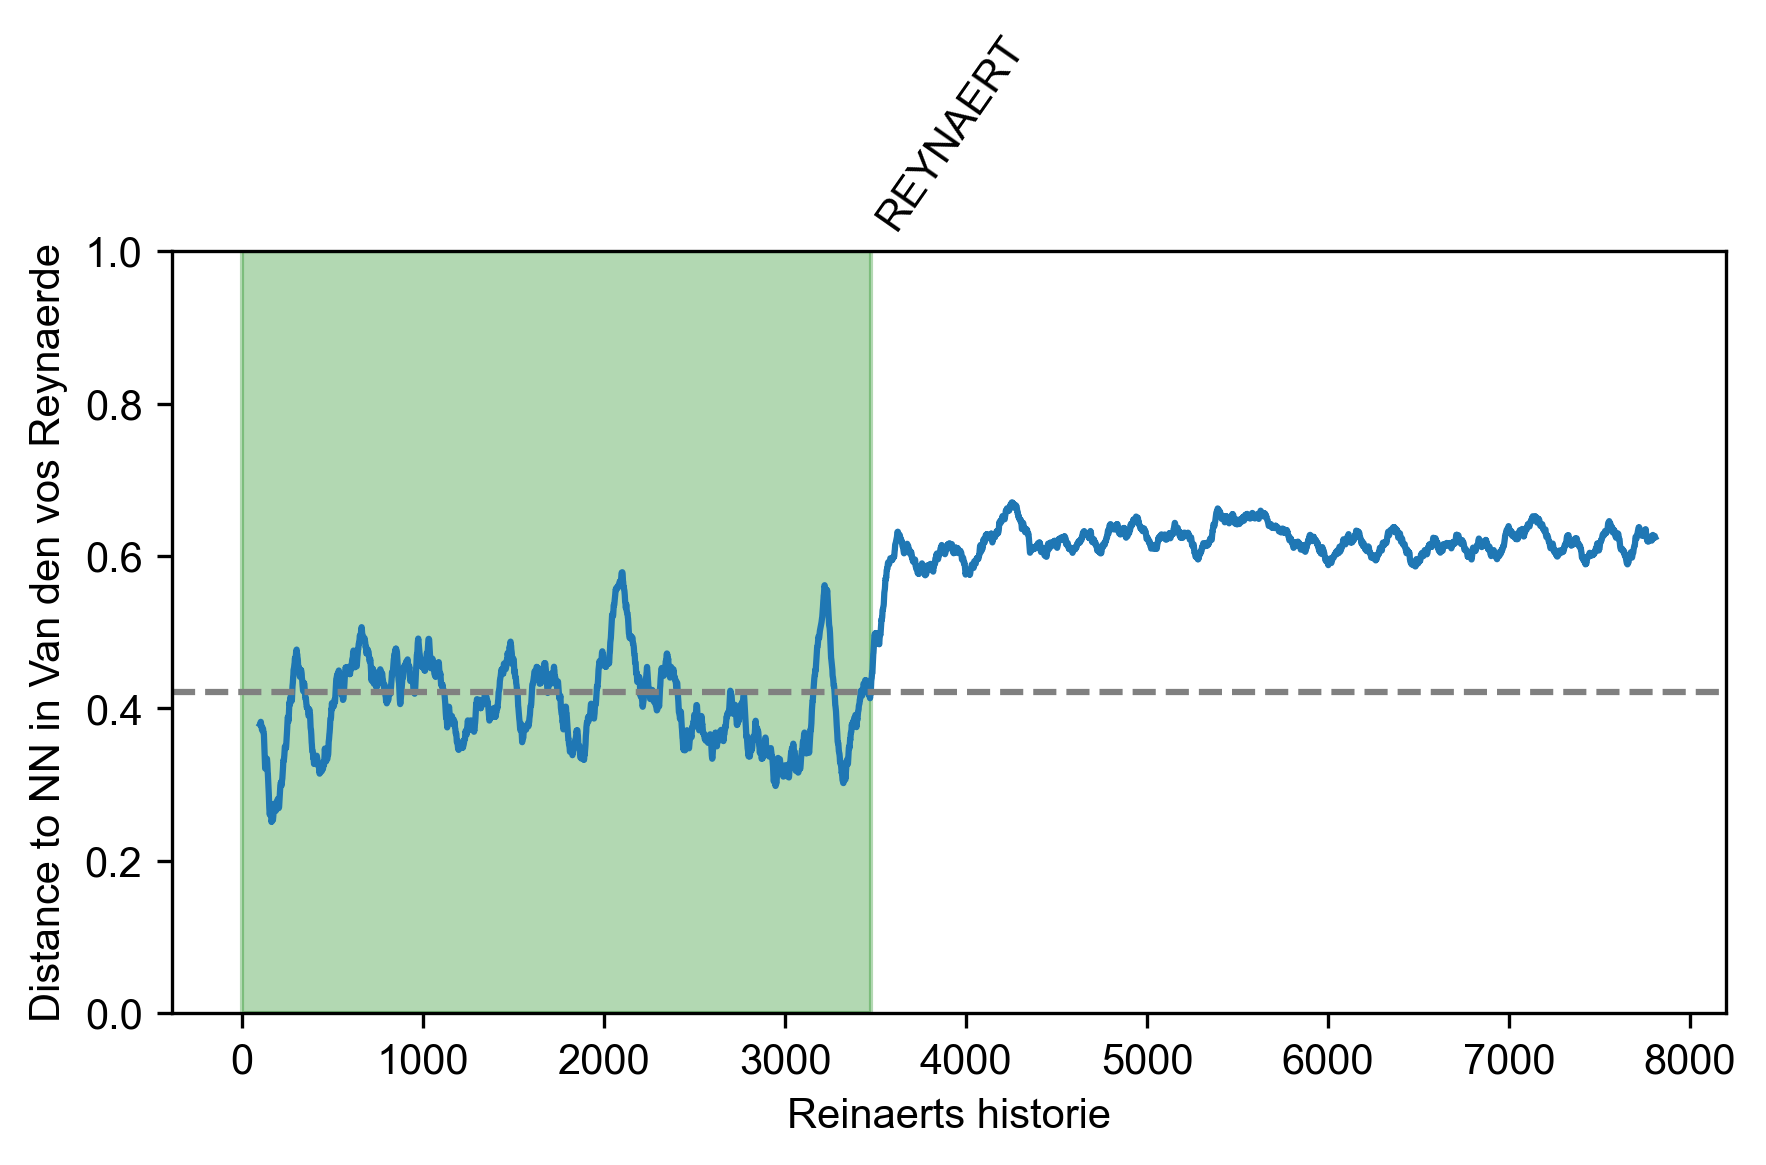

In [58]:
t1, t2 = 'Reinaerts historie', 'Van den vos Reynaerde'
distances = pairwise(t1, t2, rhyme_weight=optim_rw)
min_dists = pd.Series(distances.min(axis=1))
ax = plot_min_distance_nn(t1, t2, min_dists, threshold=optim_th, rolling_size=100);
interpol_idxs, interpol_names = get_interpolations(t1)
for (start, end), n in zip(interpol_idxs, interpol_names):
    if not 'gebed' in n:
        ax.axvspan(start, end, alpha=0.3, color='green', lw=1)
        plt.annotate(n, xy=[end, 1.03], annotation_clip=False, rotation=55)
plt.tight_layout()
plt.savefig(f'{fig_dir}/reinaert.png');

#### Large-scale detection

In [ ]:
chiv_titles = meta_df[meta_df['genre'] == 'Epiek']['title'].unique()
chiv_titles

In [ ]:
results = []
for t1, t2 in tqdm(list(product(chiv_titles, chiv_titles))):
    if t1 == t2:
        continue
    distances = pairwise(t1, t2, rhyme_weight=optim_rw, batch_size=10000)
    min_dists = pd.Series(distances.min(axis=1))
    results.append((t1, t2, min_dists))

In [ ]:
results = pd.DataFrame(results, columns=('t1', 't2', 'nn'))
results

In [ ]:
rolling_size = 100
for _, r in results.iterrows():
    if np.any(r['nn'].rolling(rolling_size).mean() < threshold):
        plot_min_distance_nn(r['t1'], r['t2'], r['nn'],
                             threshold=threshold, rolling_size=rolling_size);

## Meso-scale intertextuality

Case studies in sutbler intertextual connections as the MESO-scale. For this, we set the rhyme weight to 0.
- Prieel-scene Limborch vs Historie van Troyen
- River scene: Walewein vs Moriaen
- Hart-scene Ferguut vs Limborch

In [59]:
def load_meso_text(fn, title, group_size=None):
    work_tokens, work_lemmas = [], []
    for tok, lem, intertext_id in parse_xml(fn):
        work_tokens.append(tok)
        work_lemmas.append(lem)

    verse_tokens = [' '.join(v) for v in work_tokens]
    verse_lemmas = [' '.join(v) for v in work_lemmas]
    
    if not group_size:
        group_size = len(verse_tokens)

    verse_group_tokens = list(get_verse_groups(verse_tokens, size=group_size))
    verse_group_lemmas = list(get_verse_groups(verse_lemmas, size=group_size))
    
    meso = pd.DataFrame(zip([title] * len(verse_group_tokens), verse_group_tokens, verse_group_lemmas),
                      columns=('title', 'tokens', 'lemmas'))
    meso = add_rhyme_column(meso)
    
    return group_size, meso

def top_meso(A, B, rhyme_weight, k=3):
    AX = vec.transform(A['lemmas']) + rhyme_weight * vec.transform(A['rhyme'])
    BX = vec.transform(B['lemmas']) + rhyme_weight * vec.transform(B['rhyme'])
    D = pd.Series(pairwise_distances(BX, AX, metric='cosine').min(axis=1))
    top_idxs = D.argsort()[:k]
    top_hits = B.iloc[top_idxs].copy()
    top_hits['distance'] = D[top_idxs]
    return top_hits

In [60]:
group_size, prieel = load_meso_text(fn='../data/meso/prieel.xml', title='Prieel')
_, HvT = load_meso_text(fn='../data/xml/roman_van_limborch.xml', title='Limborch',
                        group_size=group_size)
top_meso(prieel, HvT, rhyme_weight=0, k=20)

,title,tokens,lemmas,rhyme,distance
7369,Limborch,Soe langhe reet die ridder coene / Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware / Die ridder peinsde eer ic vort vare / Willic mi hier een luttel rusten / Het mochts elken mensce lusten / Te rustene in alsoe sconer stede / Hi beete neder ende dede / Siin ors peistren gaen int gras,zo lang rijden de ridder koen / dat hij een morgen voor noen / komen in een schoon vergier / in midden staan een eglendier / boven een schoon fontein / ik zullen al de schoonheid rein / prijzen het zijn ik te zwaar / de fontein zijn ook zo klaar / dat wonder te zeggen zijn / de ridder peinzen eer ik voort varen / ik willen ik hier een luttel rusten / het mogen elk mens lusten / te rusten in alzo schoon stad / hij beten neder en doen / zijn hors peister gaan het in gras,koen noen vergier eglendier fontein rein zwaar klaar zijn varen rusten lusten stad doen gras,0.665624
7363,Limborch,Ende voeren te Grieken waert / Nu latic staen van hare vaert / Ende seggu van Echites voert / Dien de minne sere cort / Ende reet berch ende dal / Gode hi hem altoes beval / Soe langhe reet die ridder coene / Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware,en varen te n(prop) waart / nu ik laten staan van haar vaart / en zeggen du van ethites voorts / die de minne zeer kort / en rijden berg en dal / n(prop) hij hij altoos bevelen / zo lang rijden de ridder koen / dat hij een morgen voor noen / komen in een schoon vergier / in midden staan een eglendier / boven een schoon fontein / ik zullen al de schoonheid rein / prijzen het zijn ik te zwaar / de fontein zijn ook zo klaar / dat wonder te zeggen zijn,waart vaart voorts kort dal bevelen koen noen vergier eglendier fontein rein zwaar klaar zijn,0.669335
7370,Limborch,Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer / Dat wonder te seggen ware / Die ridder peinsde eer ic vort vare / Willic mi hier een luttel rusten / Het mochts elken mensce lusten / Te rustene in alsoe sconer stede / Hi beete neder ende dede / Siin ors peistren gaen int gras / Hi ghinc liggen als ict las,dat hij een morgen voor noen / komen in een schoon vergier / in midden staan een eglendier / boven een schoon fontein / ik zullen al de schoonheid rein / prijzen het zijn ik te zwaar / de fontein zijn ook zo klaar / dat wonder te zeggen zijn / de ridder peinzen eer ik voort varen / ik willen ik hier een luttel rusten / het mogen elk mens lusten / te rusten in alzo schoon stad / hij beten neder en doen / zijn hors peister gaan het in gras / hij gaan liggen als het ik lezen,noen vergier eglendier fontein rein zwaar klaar zijn varen rusten lusten stad doen gras lezen,0.675814
7362,Limborch,Ghereiden hem met bliitheden / Ende voeren te Grieken waert / Nu latic staen van hare vaert / Ende seggu van Echites voert / Dien de minne sere cort / Ende reet berch ende dal / Gode hi hem altoes beval / Soe langhe reet die ridder coene / Dat hi een marghens vor noene / Quam in enen sconen vergier / In midden stont enen eglentier / Boven ene scone fonteyne / Soudic al die sconeit reyne / Prisen het ware mi te swaer / Die fonteyne was oec soe claer,gereden hij met blijheid / en varen te n(prop) waart / nu ik laten staan van haar vaart / en zeggen du van ethites voorts / die de minne zeer kort / en rijden berg en dal / n(prop) hij hij altoos bevelen / zo lang rijden de ridder koen / dat hij een morgen voor noen / komen in een schoon vergier / in midden staan een eglendier / boven een s

Walewein-passage in Moriaen: vs. 3676 (*Mettien quam hi up ene riviere*) t.e.m. vs. 3856 (*Ende hare twier scachte braken*)

In [61]:
group_size, rivier = load_meso_text(fn='../data/meso/rivier.xml', title='Rivier')
_, Mor = load_meso_text(fn='../data/xml/roman_van_moriaen.xml', title='Moriaen',
                        group_size=group_size)
display(rivier)
top_meso(rivier, Mor, rhyme_weight=0, k=3)

title  \
0  Rivier   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

title  \
1221  Moriaen   
1222  Moriaen   
1220  Moriaen   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

Naar [Knuttel](https://www.dbnl.org/tekst/_tij003194401_01/_tij003194401_01_0003.php).
Hart-passage (niet duidelijk afgegrensd door eerdere onderzoekers) uit Ferguut: vs. 1365 (*Arger ben ic dan een dief*) - vs. 1453 (*Algader hoet met haer stoet ende ware*)

In [62]:
group_size, hart = load_meso_text(fn='../data/meso/hart.xml', title='Hart')
_, Lim = load_meso_text(fn='../data/xml/roman_van_limborch.xml', title='Limborch',
                        group_size=group_size)
display(hart)
top_meso(hart, Lim, rhyme_weight=0, k=1)

,title,tokens,lemmas,rhyme
0,Hart,Arger ben ic dan een dief / Dat ic den genen wille hebben lief / Die ic noit en sach meer dan heden / Noch en sprac in eneger steden / Morgen so sal hi orlof / Betide nemen ende ltrumen thofgt / Dan sal hi nemmer van mi weten / Saen sal hi mijns vergeten / In weet hoes hem gedinken mochte / Dade hi altenen in sijn gedochte / Daer hi quame alle ioncfrouwen / Het ware heme quaet te minen trouwen / Hi vaert tielec wech metten dage / Hoe sal hi geweten mine clage / Hoe wel dat icken minnen mach / Hi sal mi geuen den doet slach / Wisti dat ic in selken vare / In allen stonden dore hem ware / Hine dade nemmer die dorperheltidegt / Dat hi mi sine minne ontseide / Secgict hem niet hine weet nommer / Wi seggict hem ic segge mi commer / Waer soudic nemen die gedachte / Ic soude onneren mijn geslachte / Ic lage mi lieuer jndie doet kiste / Dan hijt van minen monde wiste / Wat doe ic dan ic sal wech vlien / Om enen andren salic spien / In willen sien in al mijn leuen / Mijn vader wille mi emmer geuen / Enen hogen prinche enen coninc / Vele scoenre dan desen jongelinc / Ay scoenren wat hebbic geseit / So sconen ware mi onghereit / Want niewer sijn genoet es / Wiste hi doch hoet met mi es / Ende icken lachterde so sere / Hine minde mi nemmermere / Want hine mint mi groet no clene / Gisteren so sat hi bi mi allene / Hine sprac te mi wert noit entwint / Dat haddi haddi mi ghemint / Ic wane hijs niet togen en can / Wat soudic minnen selken man / Morgen vroe alst sal graken / Sal lthi hemgt betide wech maken / Hier en blijft niet sine scoenheit / Soe sal hi mi sijn onghereit / Sine scoenheit wat bestaetsi mi / Waer omme spreke ic ende twi / Sal icse heme nemen ende sine cracht / Neen ic bider goeder nacht / Mi ware leet sine mesquame / Ic gaue heme eer dan ic hem name / Dus leit die joncfrouwe in pinen / Si versucht sere ende waent verdwinen / Die minne dat spel haer leert / Menechfout si hare op tbedde keert / Dus gelt die minne achter lande / Den ridders haer saut menegerande / Der ioncfrouwen heft ltsgtijs oec gegeuen / Sine werdes quite in al haer leuen / Het was hare vtermaten leet / Datter ferguut niet af enweet / Si hadde sochter die pine gehouden / Hadde die ridder geweest vergouden / Bedi hadsijs te meerren pant / Inharen rade datsi vant / Datsi vanden bedde wille op staen / Ende tote fergute gaen / Die tote hare niet een twint / En peinst no weet dat sine mint / Si stac ane haer hemde sidijn / Ende i pelse hermerijn / Stillekine es si gegaen / Toter cameren ende heftse ondaen / Al met ghemake ginc si vort / Haer ware leet haddement gehort / Toten bedde dat si quam / Ferguut si slapende vernam / Si stont al pensende i lanc stic / Wacharme seitsi wat salic / Ten ridder secgen als hi ontwaect / Wel naer hadsi haer weder gemaect / Teltngt bedde daer si lach te voren / Maer die minne riet hare in doreltngt / Datsine wecte liselike / Den ridder ende seide hem hastelike / Algader hoet met haer stoet ende ware,erg zijn ik dan een dief / dat ik de gene willen hebben lief / die ik nooit ne zien meer dan heden / nog ne spreken in enig stad / morgen zo zullen hij oorlof / bijtijden nemen en metrustem het hoofd / dan zullen hij nimmer van ik weten / zaan zullen hij ik vergeten / in weten hoe hij gedenken mogen / doen hij alteeen in zijn gedachte / daar hij komen al jonkvrouw / het zijn hij kwaad te mijn trouw / hij varen tijdelijk weg de met dag / hoe zullen hij geweten mijn klaag / hoe wel dat hij ik minnen mogen / hij zullen ik geven de dood slag / gij weten dat ik in zulk vaar / in al stond door hij zijn / hij ne doen nimmer de dorperdigheid / dat hij ik zijn minne ontzeggen / het hij niet hij ne weten nimmer / wij het ik zeggen hij ik zeggen ik kommer / waar ik zullen nemen de gedachte / ik zullen oneren mijn geslacht / ik liggen ik lief de in doen kist / dan het hij van mijn mond weten / wat doen ik dan ik zullen weg vlieden / om een ander ik zullen spieden / in wil zien in al mijn leven / mijn vader willen i

,title,tokens,lemmas,rhyme,distance
12271,Limborch,Bi mi dies ic werdich niet en ben / Dat hi soe sinen sen / Ane mi gheleit heeft daer hi al / Ere bi vergheten sal / Dore mi es hi ter werelt doet / Die van dogeden es sonder ghenoet / Dat ic scone was dats scade / Ende dat mi bi minnen rade / Soe vromen riddre wert te quiste / Ende sine daet soe ghesiste / Hi es bi mi verloren al / Bi gode dat ic betren sal / Want heymelec willic hem ontgaen / Ane sinen mont custe sine saen / Menichwerf ende weende sere / Ende bevalne onsen here / Siin hoeft leide si hem op tgras / Seide dWalsch daer ict in las / Ende liep allene weghe / God onse here gheve haer seghe / Want wel heeft si te doene dat / Soe verre liep si dat si in de stad / Te Venegien quam ghegaen / Ende si begonste te werken saen / Met siden dat si conste bat / Dan iemen dede in de stad / Dus bleef sie woenende daer / Maer altoes was haer therte swaer / Om hare lief daer si af sciet / Int wout daer sine liet / Doch wart si daer soe liefgetal / Van haren ghebueren al / Dat sise priisden utermaten / Alle die bi hare saten / Ende si wandelde vriendelike / Beide met armen ende met rike / Van der vrouwe latic bliven / Ende wille u vort bescriven / Van den riddre daer si af sciet / Int wout ende slapende liet / Doe hi ontspranc ende niene vant / Die conincginne riep hi te hant / Ay keytiif wat sal ic doen / Ic hebbe miin vrouwe van Arragoen / Met quader hoeden verloren / Acharmen wan waric te voren / Bleven doet eer icse verloes / Ic wane nie man en coes / Soe grote scade alse mi / Es ghesciet waer mach si / Siin ghevaren mi wondert dat / Inne weet diewile si hier sat / Ofse mi iemen heeft ontfoert / Neent si hadde mi gheroert / Soe dat ic ontsprongen ware / Neent si es geloepen hare entare / Al wenende achter woude / Doe riep die ridder met ongedoude / Vrouwe vrouwe wat hi mochte / Ic weet wel dat hise sochte / In dat wout verre of bi / Hier binnen soe quam hi / Gaende op ene grote valeye / Daer hi hoerde met ghescreye / Ene maget ende enen ridder stout / Diese hadde genomen int wout / Ende hi slouchse in hare ansichte / Meneghen slach wel bedichte / Her Evax waende mettesen / Dat die sine hadde ghewesen / Ende volgede den riddre an / Die riddre seide tote hem her man / Keert uwer straten / Of ic doe u tleven laten / Twi volgedi mi laet mi riden / Die riddere was in allen siden / Wel ghewapent toten teen / Ende her Evax volgedem al in een / Omdat hi gherne die jonfrouwe sage / Die riddre seide te dinen droeven daghe / Soutu mi volghen wetic wale / Evax seide laet mi die smale / Besien ic kere weder dan / Die riddre seide es die man / Verwoet ic wane en trouwen jay / Her dorper ghi maect te groet gecray / Ic sal u slaen met minen spere / Het sal u al u leven deren / Her Evax seide ghi dreicht om niet,bij ik dat ik waardig niet ne zijn / dat hij zo zijn zin / aan ik leggen hebben daar hij al / eer bij vergeten zullen / door ik zijn hij de te wereld doen / die van deugd zijn zonder genoot / dat ik schoon zijn dat zijn schade / en dat ik bij min raad / zo vroom ridder worden te kwisten / en zijn doen zo gezisten / hij zijn bij ik verliezen al / bij n(prop) dat ik beteren zullen / want heimelijk ik willen hij ontgaan / aan zijn mond kussen ne zaan / menig en wenen zeer / en bevelen ons heer / zijn hoofd leggen zij hij op het gras / zeggen dwals daar het ik in lezen / en lopen alleen weg / god ons heer geven haar zeggen / want wel hebben zij te doen dat / zo ver lopen zij dat zij in de stad / te venigen komen gaan / en zij beginnen te werk zaan / met zijde dat zij kunnen bidden / dan iemand doen in de stad / dus blijven zij wonen daar / maar altoos zijn zij hart het zwaar / om haar lief daar zij af scheiden / het in woud daar hij zij laten / doch worden zij daar zo liefgetal / van haar gebuur al / dat zij zij prijzen uitermate / al die bij zij zitten / en zij wandelen vriendelijk / beide met arm en met rijk / van de vrouw ik laten blijven / en willen gij voort beschrijven / van de ridde

But would it have selected the hart-passage from *all texts*?

In [63]:
nns = []
group_size, hart = load_meso_text(fn='../data/meso/hart.xml', title='Hart')
chiv = meta_df[meta_df['genre'] == 'Epiek'][['id', 'title']]
for fn, title in zip(chiv['id'], chiv['title']):
    try:
        _, trg = load_meso_text(fn=f'../data/xml/{fn}.xml', title=title,
                                group_size=group_size)
        nn = top_meso(hart, trg, rhyme_weight=0, k=1)
        nns.append(nn)
    except ValueError:
        continue

Rivier-passage?

In [64]:
nns = []
group_size, rivier = load_meso_text(fn='../data/meso/rivier.xml', title='Rivier')
chiv = meta_df[meta_df['genre'] == 'Epiek'][['id', 'title']]
for fn, title in zip(chiv['id'], chiv['title']):
    print(fn, title)
    try:
        _, trg = load_meso_text(fn=f'../data/xml/{fn}.xml', title=title,
                                group_size=group_size)
        nn = top_meso(rivier, trg, rhyme_weight=0, k=1)
        nns.append(nn)
    except ValueError:
        continue

alexanders_geesten Alexanders geesten
Alexiuslegende Alexiuslegende
anatomie_van_de_mens Anatomie van de mens
arturs_doet Arturs doet
aubri_de_borgengoen Aubri de Borgengoen
barlaam_en_josaphat_fragm_go Barlaam en Josaphat
barlaam_en_josaphat_fragm_ge Barlaam en Josaphat
beatrijs Beatrijs
bediedenisse_van_der_missen Bediedenisse van der missen
beerte_metten_breden_voeten Beerte metten breden voeten
beginsel_der_oorlogen_van_luyck Beginsel der oorlogen van Luyck
boec_exemplaer Boec Exemplaer
boec_van_den_houte Boec van den houte
dat_boec_vander_wraken Boec vander wraken
Boeve van Hamtone Boeve van Hamtone
borchgrave_van_couchi Borchgrave van Couchi
borchgrave_van_couchi_fragm_a Borchgrave van Couchi
borchgrave_van_couchi_fragm_br Borchgrave van Couchi
borchgrave_van_couchi_fragm_dp Borchgrave van Couchi
borchgravinne_van_vergi__1 Borchgravinne van Vergi (1)
borchgravinne_van_vergi__2 Borchgravinne van Vergi (2)
boudewijn_van_seborch_fragm_a Boudewijn van Seborch
boudewijn_van_seborch_fr

spiegel_historiael__4_velthem__fragm_m Spiegel historiael (P4)
spiegel_historiael__4_velthem__fragm_l Spiegel historiael (P4)
spiegel_historiael__5 Spiegel historiael (P5)
de_spieghel_der_menscheliker_behoudenesse Spieghel der menscheliker behoudenesse
theophilus Theophilus
tien_plaghen Tien plaghen ende die tien ghebode
roman_van_torec Torec
Tristant Tristant
valentijn_en_nameloos_fragm_be Valentijn en Nameloos
valentijn_en_nameloos_fragm_ge Valentijn en Nameloos
van_den_derden_eduwaert Van den derden Eduwaert
van_den_neghen_besten__kort Van den neghen besten (kort)
van_den_neghen_besten__lang Van den neghen besten (lang)
van_den_vii_vroeden_van_binnen_rome Van den VII Vroeden van binnen Rome
van_den_vijf_vrouden Van den vijf vrouden
van_den_vos_reynaerde Van den vos Reynaerde
maanzodiologium Van der manen zeden
van_der_wive_wonderlijcheit_lang Van der wive wonderlijcheit (lange versie)
van_ghevene Van ghevene
van_saladijn Van Saladijn
van_sente_brandane Van sente Brandane
van_ses_vae

In [65]:
nns = pd.concat(nns)
nns = nns.sort_values(by='distance')
nns.head(10)

title  \
3675   Walewein                                  
1221   Moriaen                                   
8848   Lancelot                                  
207    Riddere metter mouwen                     
4935   Lantsloot van der Haghedochte             
1815   Ferguut                                   
524    Lanceloet en het hert met de witte voet   
12324  Limborch                                  
14     Flandrijs                                 
2351   Perchevael                                

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Interessante lijst van treffers (over schaamte?), maar *Limborch* komt erg laag in de rangschikking.

In [66]:
nns = []
group_size, prieel = load_meso_text(fn='../data/meso/prieel.xml', title='Prieel')
chiv = meta_df[meta_df['genre'] == 'Epiek'][['id', 'title']]
for fn, title in zip(chiv['id'], chiv['title']):
    print(fn, title)
    try:
        _, trg = load_meso_text(fn=f'../data/xml/{fn}.xml', title=title,
                                group_size=group_size)
        nn = top_meso(prieel, trg, rhyme_weight=0, k=1)
        nns.append(nn)
    except ValueError:
        continue

alexanders_geesten Alexanders geesten
Alexiuslegende Alexiuslegende
anatomie_van_de_mens Anatomie van de mens
arturs_doet Arturs doet
aubri_de_borgengoen Aubri de Borgengoen
barlaam_en_josaphat_fragm_go Barlaam en Josaphat
barlaam_en_josaphat_fragm_ge Barlaam en Josaphat
beatrijs Beatrijs
bediedenisse_van_der_missen Bediedenisse van der missen
beerte_metten_breden_voeten Beerte metten breden voeten
beginsel_der_oorlogen_van_luyck Beginsel der oorlogen van Luyck
boec_exemplaer Boec Exemplaer
boec_van_den_houte Boec van den houte
dat_boec_vander_wraken Boec vander wraken
Boeve van Hamtone Boeve van Hamtone
borchgrave_van_couchi Borchgrave van Couchi
borchgrave_van_couchi_fragm_a Borchgrave van Couchi
borchgrave_van_couchi_fragm_br Borchgrave van Couchi
borchgrave_van_couchi_fragm_dp Borchgrave van Couchi
borchgravinne_van_vergi__1 Borchgravinne van Vergi (1)
borchgravinne_van_vergi__2 Borchgravinne van Vergi (2)
boudewijn_van_seborch_fragm_a Boudewijn van Seborch
boudewijn_van_seborch_fr

spiegel_historiael__4_velthem__fragm_m Spiegel historiael (P4)
spiegel_historiael__4_velthem__fragm_l Spiegel historiael (P4)
spiegel_historiael__5 Spiegel historiael (P5)
de_spieghel_der_menscheliker_behoudenesse Spieghel der menscheliker behoudenesse
theophilus Theophilus
tien_plaghen Tien plaghen ende die tien ghebode
roman_van_torec Torec
Tristant Tristant
valentijn_en_nameloos_fragm_be Valentijn en Nameloos
valentijn_en_nameloos_fragm_ge Valentijn en Nameloos
van_den_derden_eduwaert Van den derden Eduwaert
van_den_neghen_besten__kort Van den neghen besten (kort)
van_den_neghen_besten__lang Van den neghen besten (lang)
van_den_vii_vroeden_van_binnen_rome Van den VII Vroeden van binnen Rome
van_den_vijf_vrouden Van den vijf vrouden
van_den_vos_reynaerde Van den vos Reynaerde
maanzodiologium Van der manen zeden
van_der_wive_wonderlijcheit_lang Van der wive wonderlijcheit (lange versie)
van_ghevene Van ghevene
van_saladijn Van Saladijn
van_sente_brandane Van sente Brandane
van_ses_vae